<a href="https://colab.research.google.com/github/gurovic/MLCourse/blob/main/138_data_split.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Разделение данных на тренировочные, валидационные и тестовые

## Почему нужно разделять данные?
При создании моделей машинного обучения **критически важно** оценивать их работу на данных, которые не использовались при обучении. Это позволяет:
1. Избежать **переобучения** (когда модель запоминает шум в данных)
2. Оценить **реальную обобщающую способность** модели
3. Правильно **сравнивать разные модели** между собой

## Стандартные подходы к разделению

### 1. Традиционное разделение (70/15/15)

In [21]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

# Генерируем случайные данные
X, y = make_classification(n_samples=100, n_features=12, n_classes=2,
                           n_clusters_per_class=1, random_state=42)

# Первое разделение: тренировочная и временная выборки
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Второе разделение: тренировочная и валидационная
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.176, random_state=42)  # 0.176 ≈ 15%/85%

print(f"Тренировочные: {len(X_train)} ({len(X_train)/len(X):.0%})")
print(f"Валидационные: {len(X_val)} ({len(X_val)/len(X):.0%})")
print(f"Тестовые: {len(X_test)} ({len(X_test)/len(X):.0%})")

Тренировочные: 70 (70%)
Валидационные: 15 (15%)
Тестовые: 15 (15%)


### 2. Кросс-валидация (K-Fold)
Идеально для небольших наборов данных:

In [22]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)
for fold, (train_index, val_index) in enumerate(kf.split(X)):
    print(f"Fold {fold+1}:")
    print(f"  Тренировочные: индекс {train_index[:3]}...")
    print(f"  Валидационные: индекс {val_index[:3]}...")

Fold 1:
  Тренировочные: индекс [1 2 3]...
  Валидационные: индекс [ 0  4 10]...
Fold 2:
  Тренировочные: индекс [0 1 2]...
  Валидационные: индекс [ 5  9 11]...
Fold 3:
  Тренировочные: индекс [0 1 2]...
  Валидационные: индекс [3 6 7]...
Fold 4:
  Тренировочные: индекс [0 1 2]...
  Валидационные: индекс [32 41 43]...
Fold 5:
  Тренировочные: индекс [0 3 4]...
  Валидационные: индекс [ 1  2 14]...


## Практические рекомендации

### Для разных типов задач:
| Тип задачи               | Рекомендуемое разделение          |
|--------------------------|-----------------------------------|
| Классификация изображений | Стратифицированное разделение    |
| Временные ряды           | Хронологическое разделение       |
| Несбалансированные данные| Стратифицированное разделение    |
| Большие наборы данных    | 98%/1%/1% или 99%/0.5%/0.5%      |

### Важные нюансы:
1. **Стратификация** (сохранение распределения классов):

In [23]:
# Добавляем stratify=y для сохранения пропорций
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

2. **Хронологическое разделение** для временных рядов:

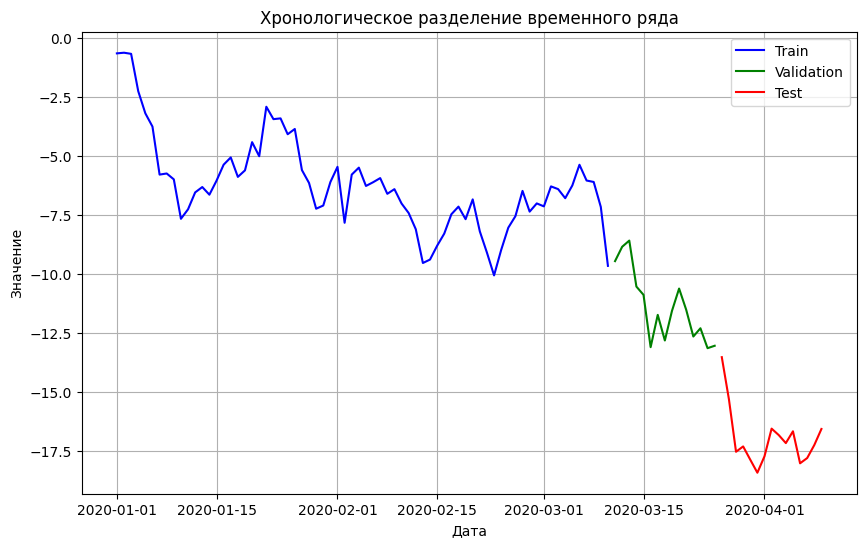

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Создаем пример временного ряда
dates = pd.date_range(start='2020-01-01', periods=100, freq='D')
values = np.random.randn(100).cumsum()

# Преобразуем в массив признаков и целевую переменную
X = np.arange(len(dates)).reshape(-1, 1)  # Номер дня как признак
y = values  # Значения временного ряда
timestamps = dates  # Сохраняем метки времени

# Хронологическое разделение
sorted_indices = np.argsort(timestamps)
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))

train_idx = sorted_indices[:train_size]
val_idx = sorted_indices[train_size:train_size+val_size]
test_idx = sorted_indices[train_size+val_size:]

# Разделение данных
X_train, X_val, X_test = X[train_idx], X[val_idx], X[test_idx]
y_train, y_val, y_test = y[train_idx], y[val_idx], y[test_idx]

# Визуализация
plt.figure(figsize=(10, 6))
plt.plot(timestamps[train_idx], y_train, 'b-', label='Train')
plt.plot(timestamps[val_idx], y_val, 'g-', label='Validation')
plt.plot(timestamps[test_idx], y_test, 'r-', label='Test')
plt.title('Хронологическое разделение временного ряда')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.grid(True)
plt.show()

3. **Предобработка данных**:
- Все преобразования (масштабирование, заполнение пропусков) должны **обучаться только на тренировочных данных**
- Затем применять обученные преобразования к валидационным и тестовым данным

In [25]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)  # Только transform!
X_test_scaled = scaler.transform(X_test)  # Только transform!

## Частые ошибки
1. **Тестовая выборка используется для обучения**:
   - Любая настройка гиперпараметров на тестовых данных приводит к оптимистичной оценке
   
2. **Утечка данных**:
   - Когда информация из тестовых данных попадает в тренировочные
   - Решение: разделять данные ДО любой обработки

3. **Непредставительная выборка**:
   - Когда распределение в тестовых данных не соответствует реальным данным
   - Решение: стратификация и случайное перемешивание

> "Тестовая выборка должна оставаться в 'сейфе' до финальной оценки модели. Представьте, что это экзаменационный билет - вы же не даете студентам учить ответы на конкретные вопросы перед экзаменом!"

## Пример полного пайплайна

In [26]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# 1. Создаем синтетические данные
np.random.seed(42)
X = np.random.rand(1000, 5)  # 1000 образцов, 5 признаков
y = np.random.randint(0, 2, size=1000)  # Бинарная классификация

# 2. Первичное разделение (тренировочная + тестовая)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.15,
    stratify=y,
    random_state=42
)

# 3. Вторичное разделение (тренировочная + валидационная)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.176,  # 0.176 ≈ 15%/85%
    stratify=y_temp,
    random_state=42
)

# 4. Предобработка (только на тренировочных данных)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# 5. Обучение модели
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# 6. Оценка на валидационных данных
val_pred = model.predict(X_val_scaled)
val_acc = accuracy_score(y_val, val_pred)
print(f"Validation Accuracy: {val_acc:.4f}")

# 7. Финальная оценка на тестовых данных
test_pred = model.predict(X_test_scaled)
test_acc = accuracy_score(y_test, test_pred)
print(f"Test Accuracy: {test_acc:.4f}")

# 8. Проверка размеров выборок
print(f"\nРазмеры выборок:")
print(f"Train: {X_train.shape[0]} samples")
print(f"Val: {X_val.shape[0]} samples")
print(f"Test: {X_test.shape[0]} samples")


Validation Accuracy: 0.4933
Test Accuracy: 0.4800

Размеры выборок:
Train: 700 samples
Val: 150 samples
Test: 150 samples
